In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
%load_ext rpy2.ipython

In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
behavior = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/behavioral_data_SVs.csv")[["sub", "trial", "gain", "loss", "condition", "RT", "delta_SV", "accept", "subj_value_norm"]]
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["loss_over_gain"] = np.log(data["loss"] / data["gain"])

In [3]:
hddm_data = data.query("timebin > .5 & timebin < 3.5").groupby(["sub", "trial", "subj_value_norm", "RT", "accept", "delta_SV"])['pupil_size'].mean().dropna().reset_index()

In [4]:
hddm_data['pupil_bin'] = hddm_data.groupby('sub')['pupil_size'].transform(
    lambda x: pd.qcut(x, 3, labels=['Low', 'Medium', 'High'])
)

In [5]:
x = hddm_data.groupby(['sub', 'pupil_bin'])[['delta_SV', 'RT', 'subj_value_norm']].mean().reset_index()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_25100/4191678084.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x = hddm_data.groupby(['sub', 'pupil_bin'])[['delta_SV', 'RT', 'subj_value_norm']].mean().reset_index()


In [7]:
hddm_data["SV_prev"] = hddm_data.groupby("sub")["subj_value_norm"].shift(1)

In [10]:
hddm_data = hddm_data.query("trial > 3")

In [11]:
hddm_data.to_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/hddm_pupil_data.csv", index=False)

<Axes: xlabel='decision_value_norm', ylabel='pupil_size'>

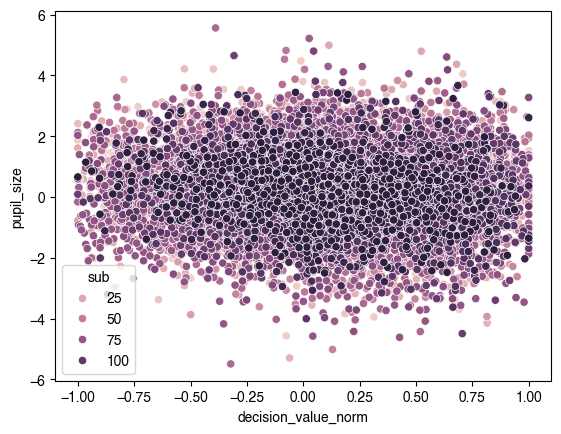

In [56]:
sns.scatterplot(data=hddm_data, x="decision_value_norm", y="pupil_size", hue = "sub")

In [42]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(dplyr)
library(broom.mixed)

In [43]:
%%R -o residual_pupil
# loop through timebins
residual_pupil <- data.frame()
# Create a copy of data with sub, loss_over_gain, gain, loss, condition

for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    # model = lmer(pupil_size ~ RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub), data=data[data$timebin == tb, ])
    model = lmer(pupil_size ~ RT + decision_value_norm + (1 | sub), data=data[data$timebin == tb, ])
    # Gather results
    residuals <- residuals(model)
    results <- data.frame(pupil_residual = residuals, 
                        timebin = tb, 
                        pupil_size = data[data$timebin == tb, "pupil_size"],
                        trial = data[data$timebin == tb, "trial"],
                        sub = data[data$timebin == tb, "sub"], 
                        gain = data[data$timebin == tb, "gain"], 
                        loss = data[data$timebin == tb, "loss"], 
                        condition = data[data$timebin == tb, "condition"], 
                        RT = data[data$timebin == tb, "RT"],
                        accept = data[data$timebin == tb, "accept"], 
                        decision_value_norm = data[data$timebin == tb, "decision_value_norm"],
                        sq_break  = data[data$timebin == tb, "delta_sq"],
                        risk_profile = data[data$timebin == tb, "risk_profile"]
    )
    residual_pupil <- rbind(residual_pupil, results)
}

In [5]:
# For each subject
residual_pupil["sq_break_q"] = residual_pupil.groupby('sub')['sq_break'].transform(
    lambda x: pd.qcut(x, 3, labels=['Low', 'Medium', 'High'])
)

In [6]:
x = residual_pupil.groupby(["sub", "timebin", "sq_break_q"])["pupil_residual"].mean().reset_index()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_58405/1316006012.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x = residual_pupil.groupby(["sub", "timebin", "sq_break_q"])["pupil_residual"].mean().reset_index()


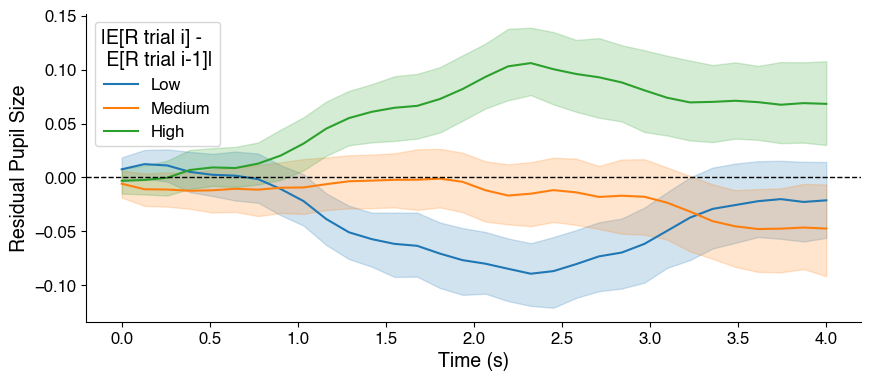

In [10]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Low': 'skyblue', 'Medium': 'deepskyblue', 'High': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=x.query("sub != 76"), x="timebin", y="pupil_residual", hue="sq_break_q", ax=ax, markers = True)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# ax.set_xlim(0, 4)
# ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Low', 'Medium', 'High']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="|E[R trial i] - \n E[R trial i-1]|", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [44]:
hddm_data = residual_pupil.query("timebin > 1.5 & timebin < 2").groupby(["sub", "trial", "decision_value_norm", "RT"])[['pupil_residual', 'pupil_size']].mean().dropna().reset_index()

In [45]:
hddm_data['pupil_bin1'] = hddm_data.groupby('sub')['pupil_residual'].transform(
    lambda x: pd.qcut(x, 3, labels=['Low', 'Medium', 'High'])
)

In [46]:
hddm_data['pupil_bin2'] = hddm_data.groupby('sub')['pupil_size'].transform(
    lambda x: pd.qcut(x, 3, labels=['Low', 'Medium', 'High'])
)

In [49]:
# Check match between pupil_bin1 and pupil_bin2
hddm_data['pupil_bin_match'] = hddm_data['pupil_bin1'] == hddm_data['pupil_bin2']
# Check if the number of trials in each bin is the same
hddm_data['pupil_bin1'].value_counts(), hddm_data['pupil_bin2'].value_counts()

(pupil_bin1
 High      4629
 Low       4603
 Medium    4593
 Name: count, dtype: int64,
 pupil_bin2
 High      4627
 Low       4602
 Medium    4596
 Name: count, dtype: int64)

In [50]:
np.sum(hddm_data['pupil_bin_match']) / len(hddm_data)  # Check the proportion of matches

np.float64(0.9666546112115733)

In [120]:
behavior = load_behavioral_data(min_RT = 0.2)
behavior["dir_opposite_prev_response"] = behavior.groupby(['sub'])['accept'].shift(1)
behavior["dir_opposite_prev_response"] = behavior["dir_opposite_prev_response"].replace({1: -1, 0: 1})

In [121]:
hddm_data = hddm_data.merge(behavior[['sub', 'trial', 'dir_opposite_prev_response', 'accept']], on=['sub', 'trial'], how='left')
hddm_data = hddm_data.dropna()

In [125]:
hddm_data

,sub,trial,decision_value_norm,RT,pupil_residual,pupil_bin,dir_opposite_prev_response,accept
0,3,4,0.191920,0.936,-0.765261,Low,-1.0,1
1,3,5,0.554370,1.142,-0.196859,Medium,-1.0,1
2,3,6,0.352343,1.145,-0.021836,Medium,-1.0,1
3,3,7,0.250538,1.040,0.375138,High,-1.0,1
4,3,8,0.242350,1.352,0.982932,High,-1.0,1
...,...,...,...,...,...,...,...,...
13820,124,252,-0.516643,1.235,1.011446,High,1.0,0
13821,124,253,-0.329067,1.236,-0.222222,Medium,1.0,0
13822,124,254,-0.693688,1.030,0.368527,High,1.0,0
13823,124,255,-0.473895,1.029,-0.503984,Low,1.0,0


In [123]:
hddm_data.to_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/hddm_pupil_data.csv", index=False)

In [ ]:
sns.barplot(data=hddm_data, x="pupil_bin", y="decision_value_norm")

KeyboardInterrupt: 

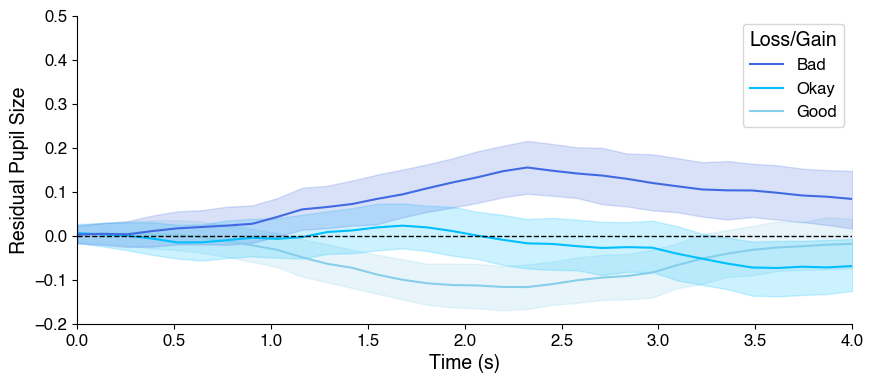

In [22]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'skyblue', 'Okay': 'deepskyblue', 'Bad': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("risk_profile == 'risk_prefered'"), x="timebin", y="pupil_residual", hue="sq_break_q", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Bad', 'Okay', 'Good']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss/Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_53423/771186522.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=residual_pupil.query("condition == 'neutral'"), x="timebin", y="pupil_residual", hue="sq_break_q", palette=color_palette, ax=ax)


ValueError: 'Bad' is not in list

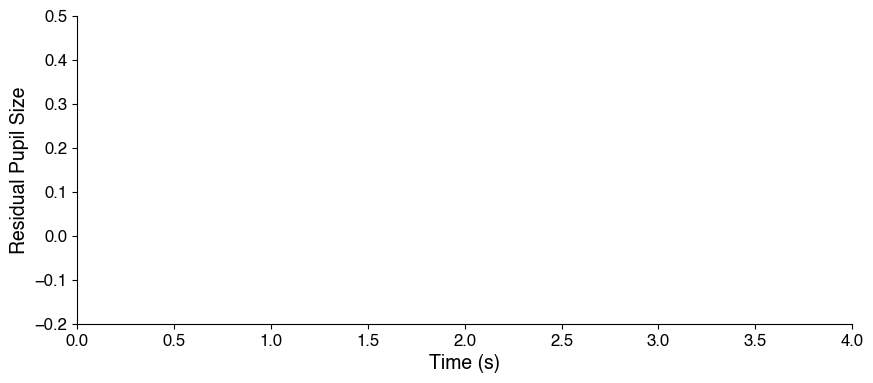

In [24]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'skyblue', 'Okay': 'deepskyblue', 'Bad': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'neutral'"), x="timebin", y="pupil_residual", hue="sq_break_q", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Bad', 'Okay', 'Good']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss/Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()